# Exercise 20

## problem 1

Find an approximate solution for the fixed point equation

$$x = e^{-x}.$$

Use $x_0 = 1.1$ as initial value and break after 1000 iterations or if the error is small enough.

In [1]:
fixp :: Double -> Int -> Double -> (Double -> Double) -> Double
fixp tol maxit x0 f = 
    case converged of
        x:_ -> x
        otherwise -> last iterates
    where iterates = take maxit $ iterate f x0
          converged = [ x | (x, xprev) <- zip (tail iterates) iterates
                          , abs (x - xprev) < tol ]

fixp 1e-5 1000 1.1 $ \x -> exp (-x)

0.5671403114945636

## problem 2

Write a function that performs simple numerical (Riemann) integration using step functions.

A function $\phi:[a,b] \rightarrow \mathbb{R}$ is called step function if there exists a partion of $[a,b]$ into intervals such that $\phi$ is constant on each interval.

In [2]:
int :: Double -> Double -> Int -> (Double -> Double) -> Double
int a b n f = (b-a) / n' * sum (map f xs)
    where xs = [ a + fromIntegral k / n' * (b-a) | k <- [0..n] ]
          n' = fromIntegral n

## problem 3

Numerically compute the derivative of $f(x) = \sin(15x)$, $x \in [0, 2\pi]$ given a vector of noisy values $f(x_k) + \epsilon_k$, for $x_k = 2 \pi k / N$, $k \in \{0, 1, \ldots, N-1\}$. Here, $\epsilon_k$ are normally distributed noise variables with mean 0 and variance $\sigma$. Compare the result to the analytical derivative by computing a suitably scaled norm of the difference, averaged over sufficiently many noise realizations, and present the results graphically for varying $N$ and $\sigma$.

*Note*: You can generate random vectors either using the standard `System.Random` functions, or

```haskell
randomVector :: Seed -> RandDist -> Int -> Vec Double
```

from `Numeric.LinearAlgebra.Repa`. As seed values for the different noise realization, you can use `[0..]` for simplicity.

In [3]:
import Graphics.Rendering.Plot
import qualified Data.Array.Repa as Repa
import Data.Array.Repa hiding (map, (++))
import Numeric.LinearAlgebra.Helpers
import Numeric.LinearAlgebra.Repa

In [4]:
periodicCentralDiff :: Vec Double -> Vec Double
periodicCentralDiff f = computeS $ fLeft -^ fRight
    where n = vlength f
          fLeft = subVector 1 (n-1) f `append` subVector 0 1 f
          fRight = subVector (n-1) 1 f `append` subVector 0 (n-1) f

In [5]:
errs :: Int -> Double -> [Double]
errs steps variance = map (err . makeNoise) [0..]
  where
    xs :: Vec Double
    xs = subVector 0 steps $ computeS $ linspace (steps + 1) (0, 2*pi)
    f :: Vec Double
    f = computeS $ Repa.map (\x -> sin (15*x)) xs
    f'exact :: Vec Double
    f'exact = computeS $ Repa.map (\x -> 15*cos (15*x)) xs
    h :: Double
    h = xs!(ix1 1) - xs!(ix1 0)
    makeNoise :: Seed -> Vec Double
    makeNoise seed = sqrt variance `hscale` randomVector seed Gaussian steps
    err :: Vec Double -> Double
    err noise = let f' = (1/(2*h)) `hscale` periodicCentralDiff (computeS (f +^ noise))
                  in sqrt h * norm2 (computeS (f'exact -^ f'))
-- TODO: this is quite haskell^Whaesslich

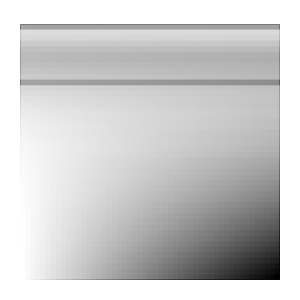

In [6]:
meanErr' :: Int -> Int -> Double -> Double
meanErr' n steps variance = (sum . take n $ errs steps variance) / fromIntegral n

meanErr :: Int -> Double -> Double
meanErr = meanErr' 100

makeResultMatrix :: [Int] -> [Double] -> Mat Double
makeResultMatrix s v = computeS $ fromFunction (ix2 ns nv) $ run
    where ns = length s
          nv = length v
          -- we plot the square of the mean error for better contrast
          run (Z :. i :. j) = meanErr (s!!i) (v!!j) ^ 2
          
setPlots 1 1 >> withPlot (1, 1) (setDataset $ fromRepa $ makeResultMatrix [10,12..100] [0,0.1..5])

In [7]:
-- The plot shows -- as expected -- an increasing error with increasing noise 
-- variance, but also a better robustness with larger step sizes. On the other
-- hand, too large step sizes lead to large errors since the approximation
-- becomes bad. There is a -- noise-dependent -- optimal step size somewhere
-- in the middle which balances these errors.

## problem 4

Consider the one-dimensional integral equation

$$\int_0^1 \phi(x)e^{-|x-y|}\sin(|x-y|)^2 dx = f(y),\quad y \in [0, 1]$$

where $\phi(x) \in \mathbb{R}$ and $f(y) = \sin(y)$. Approximate this by a discretized version

$$A \phi = f$$

with a matrix $A$ and solve the equation numerically. Check if the solution actually solves the discrete system.

In [10]:
{-# LANGUAGE FlexibleContexts #-}

import Data.Array.Repa
import Numeric.LinearAlgebra.Repa
import Numeric.LinearAlgebra.Helpers

kernel :: Double -> Double
kernel x = exp (-z) * sin z ^ (2::Int)
    where z = abs x

(//) :: Integral a => a -> a -> Double
x // y = fromIntegral x / fromIntegral y
infixl 7 //

mkMatrix :: Int -> Int -> Mat Double
mkMatrix ny nx = mat
    where mat = computeS $ fromFunction (ix2 ny nx) get
          get (Z :. iy :. ix) = (1//nx) * kernel ((ix // nx) - (iy // ny))

rhs :: Int -> Vec Double
rhs n = computeS $ fromFunction (ix1 n) $ \(Z:.k) -> sin (k // n)

run nx ny = norm2 $ computeS (y -^ y')
    where mat = mkMatrix ny nx
          y = rhs ny
          x = mat <\> y
          y' = mat `app` x
          
run 100 100


1.5919144116192791e-13